In [1]:
from pymavlink import mavutil

import matplotlib.pyplot as plt
import pandas as pd
import os
import geopandas as gpd
from shapely.geometry import Point, LineString

C:\Users\Usuario\AppData\Local\Temp\ipykernel_15776\2406777076.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [20]:
vehiculo = 'DA02'

In [21]:
path_rec = r'G:\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\SHP\RECORRIDOS.shp'
gdf_rec = gpd.read_file(path_rec)

In [22]:
if vehiculo == 'DA01':
    path_log = r'G:\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\TLOGS\ALTA_01'
elif vehiculo == 'DA02':
    path_log = r'G:\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\TLOGS\ALTA_02'
elif vehiculo == 'DA03':
    path_log = r'G:\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\TLOGS\ALTA_03'
contenido = os.listdir(path_log)
len(contenido)

698

In [23]:
# Filtrar la lista 'contenido' para excluir elementos que están en la columna 'nombre' del GeoDataFrame
contenido_filtrado = [item for item in contenido if item not in gdf_rec['nombre'].values]
len(contenido_filtrado)

16

In [24]:
def leer_logs(lista_logs):
    list_geo = []
    list_name = []
    for i in lista_logs:
        log = path_log + '/' + i
        
        name = i
        
        mlog = mavutil.mavlink_connection(log)
        lats = []
        lons = []
        while True:
            msg = mlog.recv_match()
            if not msg:
                break
            # Ejemplo de procesamiento de mensaje
            if msg.get_type() == 'GLOBAL_POSITION_INT':
                lat = msg.lat / 1e7  # Latitud en grados
                lon = msg.lon / 1e7  # Longitud en grados
                lats.append(lat)
                lons.append(lon)

        coors = {'lat':lats, 'lon':lons}
        df = pd.DataFrame(coors)
        
        geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
        line = LineString(geometry)
        list_geo.append(line)
        list_name.append(name)
    return (list_geo, list_name)

In [25]:
lineas, names = leer_logs(contenido_filtrado)

In [26]:
lineas

[<LINESTRING (0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0...>,
 <LINESTRING (0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0...>,
 <LINESTRING (0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0...>,
 <LINESTRING (0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0, 0 0...>,
 <LINESTRING (-63.313 -17.318, -63.313 -17.318, -63.313 -17.318, -63.313 -17....>,
 <LINESTRING (-63.198 -17.243, -63.198 -17.243, -63.198 -17.243, -63.198 -17....>,
 <LINESTRING (-63.02 -17.213, -63.02 -17.213, -63.02 -17.213, -63.02 -17.213,...>,
 <LINESTRING (-63.019 -17.213, -63.019 -17.213, -63.019 -17.213, -63.019 -17....>,
 <LINESTRING (-63.198 -17.243, -63.198 -17.243, -63.198 -17.243, -63.198 -17....>,
 <LINESTRING (-63.205 -17.237, -63.205 -17.237, -63.205 -17.237, -63.205 -17....>,
 <LINESTRING (-63.198 -17.243, -63.198 -17.243, -63.198 -17.243, -63.198 -17....>,
 <LINESTRING (-63.198 -17.243, -63.198 -17.243, -63.198 -17.243, -63.198 -17....>,
 <LI

In [27]:
# Crear un GeoDataFrame con los LineStrings y sus nombres
gdf_lines = gpd.GeoDataFrame({'nombre': names, 'geometry': lineas}, crs="EPSG:4326")

In [28]:
gdf_lines

,nombre,geometry
0,2024-07-15 18-37-09.tlog,"LINESTRING (0.00000 0.00000, 0.00000 0.00000, ..."
1,2024-07-24 19-53-05.tlog,"LINESTRING (0.00000 0.00000, 0.00000 0.00000, ..."
2,2024-08-05 11-06-00.tlog,"LINESTRING (0.00000 0.00000, 0.00000 0.00000, ..."
3,2024-09-02 19-36-16.tlog,"LINESTRING (0.00000 0.00000, 0.00000 0.00000, ..."
4,2025-02-11 08-24-26.tlog,"LINESTRING (-63.31327 -17.31760, -63.31327 -17..."
5,2025-02-11 18-49-51.tlog,"LINESTRING (-63.19842 -17.24302, -63.19842 -17..."
6,2025-02-11 19-24-17.tlog,"LINESTRING (-63.01951 -17.21301, -63.01951 -17..."
7,2025-02-11 21-45-22.tlog,"LINESTRING (-63.01938 -17.21304, -63.01938 -17..."
8,2025-02-11 22-29-00.tlog,"LINESTRING (-63.19832 -17.24328, -63.19832 -17..."
9,2025-02-12 08-10-33.tlog,"LINESTRING (-63.20468 -17.23692, -63.20468 -17..."


<Axes: >

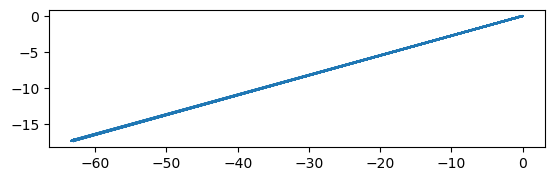

In [29]:
gdf_lines.plot()

In [30]:
# Función para dividir y limpiar las líneas
def dividir_y_limpiar_linea(linea):
    puntos = list(linea.coords)
    nuevas_lineas = []
    nueva_linea = []
    
    for punto in puntos:
        if punto != (0, 0):
            nueva_linea.append(punto)
        else:
            if nueva_linea:
                nuevas_lineas.append(LineString(nueva_linea))
                nueva_linea = []
    
    if nueva_linea:
        nuevas_lineas.append(LineString(nueva_linea))
    
    return nuevas_lineas

In [31]:
# Crear una lista para las nuevas líneas y nombres
nuevas_lineas = []
nuevos_nombres = []
for idx, row in gdf_lines.iterrows():
    lineas_divididas = dividir_y_limpiar_linea(row.geometry)
    for linea in lineas_divididas:
        nuevas_lineas.append(linea)
        nuevos_nombres.append(row['nombre'])

In [32]:
# Crear un nuevo GeoDataFrame con las nuevas líneas
gdf_lines = gpd.GeoDataFrame({'nombre': nuevos_nombres, 'geometry': nuevas_lineas}, crs="EPSG:4326")

In [33]:
# Función para contar la cantidad de coordenadas en una geometría de tipo LINESTRING
def contar_coordenadas(linea):
    return len(linea.coords)

In [34]:
gdf_lines['num_vert'] = gdf_lines['geometry'].apply(contar_coordenadas)

In [35]:
gdf_lines['vehiculo'] = vehiculo

In [36]:
gdf_lines

,nombre,geometry,num_vert,vehiculo
0,2025-02-11 08-24-26.tlog,"LINESTRING (-63.31327 -17.31760, -63.31327 -17...",1086,DA02
1,2025-02-11 08-24-26.tlog,"LINESTRING (-63.31327 -17.31760, -63.31327 -17...",687,DA02
2,2025-02-11 18-49-51.tlog,"LINESTRING (-63.19842 -17.24302, -63.19842 -17...",10803,DA02
3,2025-02-11 19-24-17.tlog,"LINESTRING (-63.01951 -17.21301, -63.01951 -17...",2371,DA02
4,2025-02-11 21-45-22.tlog,"LINESTRING (-63.01938 -17.21304, -63.01938 -17...",603,DA02
5,2025-02-11 22-29-00.tlog,"LINESTRING (-63.19832 -17.24328, -63.19832 -17...",620,DA02
6,2025-02-11 22-29-00.tlog,"LINESTRING (-63.19838 -17.24328, -63.19838 -17...",2086,DA02
7,2025-02-12 08-10-33.tlog,"LINESTRING (-63.20468 -17.23692, -63.20468 -17...",1017,DA02
8,2025-02-12 09-43-25.tlog,"LINESTRING (-63.19839 -17.24318, -63.19839 -17...",642,DA02
9,2025-02-12 09-49-37.tlog,"LINESTRING (-63.19831 -17.24331, -63.19831 -17...",433,DA02


<Axes: >

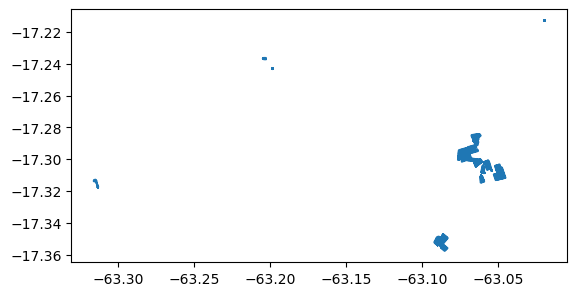

In [37]:
gdf_lines.plot()

In [38]:
gdf_lines.crs = "EPSG:4326"
gdf_lines_utm = gdf_lines.to_crs(epsg=32720)

<Axes: >

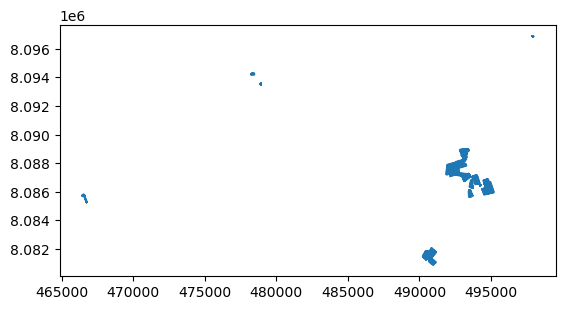

In [39]:
gdf_lines_utm.plot()

In [40]:
# Combinar los GeoDataFrames
gdf_combined = gpd.GeoDataFrame(pd.concat([gdf_rec, gdf_lines_utm], ignore_index=True))
# rellenar valores NaN
gdf_combined['idd'] = gdf_combined['idd'].fillna(0).astype(int)

In [41]:
gdf_combined

,idd,nombre,vehiculo,num_vert,id,asignado,geometry
0,1,Jul-20th-2024-08-43PM-Flight-Airdata.kml,DA03,807,1.0,si,"LINESTRING (460257.759 8096126.683, 460257.759..."
1,63,Jul-25th-2024-05-47PM-Flight-Airdata.kml,DA03,931,2.0,si,"LINESTRING (456011.255 8084542.548, 456011.265..."
2,63,Jul-25th-2024-06-51PM-Flight-Airdata.kml,DA03,1168,3.0,None,"LINESTRING (455648.848 8084842.307, 455648.848..."
3,63,Jul-25th-2024-07-06PM-Flight-Airdata.kml,DA03,1581,4.0,None,"LINESTRING (455647.763 8084843.024, 455647.752..."
4,1,Jul-25th-2024-10-42PM-Flight-Airdata.kml,DA03,1225,5.0,None,"LINESTRING (460855.506 8095707.381, 460855.527..."
...,...,...,...,...,...,...,...
2928,0,2025-02-13 05-09-58.tlog,DA02,1781,NaN,NaN,"LINESTRING (493493.273 8086101.038, 493493.273..."
2929,0,2025-02-13 05-09-58.tlog,DA02,1626,NaN,NaN,"LINESTRING (493710.495 8086299.208, 493710.463..."
2930,0,2025-02-13 05-09-58.tlog,DA02,3295,NaN,NaN,"LINESTRING (490614.293 8081536.064, 490613.432..."
2931,0,2025-02-13 06-29-34.tlog,DA02,2964,NaN,NaN,"LINESTRING (490606.485 8081534.821, 490606.495..."


In [42]:
gdf_combined.dtypes

idd            int32
nombre        object
vehiculo      object
num_vert       int64
id           float64
asignado      object
geometry    geometry
dtype: object

In [43]:
gdf_combined.to_file(path_rec, driver="ESRI Shapefile")